In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.optimize import curve_fit
import sqlite3
from scipy import integrate

import warnings

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sixdesk.da import davst, davst_function

Initialize the davst class and perform the fit on the data

In [2]:
basedir = '/media/phermes/local/DA_studies/injection_2016/db/'

In [8]:
chroma, ioct = 0,0
d = davst(basedir+"lhc_b1_inj_2016_qp_{0}_ioct_{1}.db".format(chroma,ioct),emit=2.5)
d.fit(save=True)
d.get_extrapolated_da(minutes=30,save=True)

In [40]:
for chroma in range(0,22,2):
    for ioct in range(0,44,4):
        print("lhc_b1_inj_2016_qp_{0}_ioct_{1}.db".format(chroma,ioct))
        name = basedir+"lhc_b1_inj_2016_qp_{0}_ioct_{1}.db".format(chroma,ioct)
        d = davst(name,emit=2.5)
        d.fit(save=True)
        d.get_extrapolated_da(minutes=30,save=True)

lhc_b1_inj_2016_qp_0_ioct_0.db
lhc_b1_inj_2016_qp_0_ioct_4.db
lhc_b1_inj_2016_qp_0_ioct_8.db
lhc_b1_inj_2016_qp_0_ioct_12.db
lhc_b1_inj_2016_qp_0_ioct_16.db
lhc_b1_inj_2016_qp_0_ioct_20.db
lhc_b1_inj_2016_qp_0_ioct_24.db
lhc_b1_inj_2016_qp_0_ioct_28.db
lhc_b1_inj_2016_qp_0_ioct_32.db
lhc_b1_inj_2016_qp_0_ioct_36.db
lhc_b1_inj_2016_qp_0_ioct_40.db
lhc_b1_inj_2016_qp_2_ioct_0.db
lhc_b1_inj_2016_qp_2_ioct_4.db
lhc_b1_inj_2016_qp_2_ioct_8.db
lhc_b1_inj_2016_qp_2_ioct_12.db
lhc_b1_inj_2016_qp_2_ioct_16.db
lhc_b1_inj_2016_qp_2_ioct_20.db
lhc_b1_inj_2016_qp_2_ioct_24.db
lhc_b1_inj_2016_qp_2_ioct_28.db
lhc_b1_inj_2016_qp_2_ioct_32.db
lhc_b1_inj_2016_qp_2_ioct_36.db
lhc_b1_inj_2016_qp_2_ioct_40.db
lhc_b1_inj_2016_qp_4_ioct_0.db
lhc_b1_inj_2016_qp_4_ioct_4.db
lhc_b1_inj_2016_qp_4_ioct_8.db
lhc_b1_inj_2016_qp_4_ioct_12.db
lhc_b1_inj_2016_qp_4_ioct_16.db
lhc_b1_inj_2016_qp_4_ioct_20.db
lhc_b1_inj_2016_qp_4_ioct_24.db
lhc_b1_inj_2016_qp_4_ioct_28.db
lhc_b1_inj_2016_qp_4_ioct_32.db
lhc_b1_inj_2016_q

/home/phermes/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:713: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/home/phermes/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


lhc_b1_inj_2016_qp_6_ioct_32.db
lhc_b1_inj_2016_qp_6_ioct_36.db
lhc_b1_inj_2016_qp_6_ioct_40.db
lhc_b1_inj_2016_qp_8_ioct_0.db
lhc_b1_inj_2016_qp_8_ioct_4.db
lhc_b1_inj_2016_qp_8_ioct_8.db
lhc_b1_inj_2016_qp_8_ioct_12.db
lhc_b1_inj_2016_qp_8_ioct_16.db
lhc_b1_inj_2016_qp_8_ioct_20.db
lhc_b1_inj_2016_qp_8_ioct_24.db
lhc_b1_inj_2016_qp_8_ioct_28.db
lhc_b1_inj_2016_qp_8_ioct_32.db
lhc_b1_inj_2016_qp_8_ioct_36.db
lhc_b1_inj_2016_qp_8_ioct_40.db
lhc_b1_inj_2016_qp_10_ioct_0.db
lhc_b1_inj_2016_qp_10_ioct_4.db
lhc_b1_inj_2016_qp_10_ioct_8.db
lhc_b1_inj_2016_qp_10_ioct_12.db
lhc_b1_inj_2016_qp_10_ioct_16.db
lhc_b1_inj_2016_qp_10_ioct_20.db
lhc_b1_inj_2016_qp_10_ioct_24.db
lhc_b1_inj_2016_qp_10_ioct_28.db
lhc_b1_inj_2016_qp_10_ioct_32.db
lhc_b1_inj_2016_qp_10_ioct_36.db
lhc_b1_inj_2016_qp_10_ioct_40.db
lhc_b1_inj_2016_qp_12_ioct_0.db
lhc_b1_inj_2016_qp_12_ioct_4.db
lhc_b1_inj_2016_qp_12_ioct_8.db
lhc_b1_inj_2016_qp_12_ioct_12.db
lhc_b1_inj_2016_qp_12_ioct_16.db
lhc_b1_inj_2016_qp_12_ioct_20.db


In [68]:
def compare_tlossmin_nturn(d,seed):
    for turns in [100000,30*60*11200]:
        d.fit(seeds=[seed])
        x   = np.arange(500,turns,1000)
        fp  = d.fit_params[d.fit_params['seed']==seed]
        fit = davst_function(x,fp['d'].values,fp['b'].values,fp['k'].values)
        plt.plot(d.cleaned_data['tlossmin'], d.cleaned_data['dawsimp'],'ro',label='tlossmin data')
        plt.plot(x,fit,'r',label='tlossmin fit')

        d.fit(seeds=[seed],xaxis='nturn')
        x   = np.arange(500,turns,1000)
        fp  = d.fit_params[d.fit_params['seed']==seed]
        fit = davst_function(x,fp['d'].values,fp['b'].values,fp['k'].values)
        plt.plot(d.cleaned_data['nturn'], d.cleaned_data['dawsimp'],'bo',label='nturn data')
        plt.plot(x,fit,'b',label='nturn fit')
        plt.legend()
        plt.xlabel('turn')
        plt.ylabel("dawsimp")
        plt.show()

In [41]:
output = []
for chroma in range(0,22,2):
    for ioct in range(0,44,4):
        name = basedir+"lhc_b1_inj_2016_qp_{0}_ioct_{1}.db".format(chroma,ioct)
        d    = davst(name,emit=2.5)
        exda = d.extrapolated_da['exda_1800_sec']
        output.append([chroma, ioct, exda.min(), exda.max(), exda.mean(), exda.std()])
output = pd.DataFrame(output,columns=['chroma','ioct','damin','damax','daavg','dastd'])

In [42]:
output[output['damin']<0]

,chroma,ioct,damin,damax,daavg,dastd
35,6,8,-0.498678,10.124061,4.687745,2.384185
46,8,8,-1.718654,10.788709,6.344223,3.043411


In [43]:
name = basedir+"lhc_b1_inj_2016_qp_{0}_ioct_{1}.db".format(6,8)
d    = davst(name,emit=2.5)

In [44]:
d.extrapolated_da[d.extrapolated_da['exda_1800_sec']<0]

,seed,emit,d,b,k,chi,derr,berr,exda_1800_sec
29,30.0,2.5,14.582993,-0.000884,-4.9,0.012781,0.001007,3.962061e-10,-0.498678


In [79]:
name = basedir+"lhc_b1_inj_2016_qp_{0}_ioct_{1}.db".format(8,8)
d    = davst(name,emit=2.5)
d.extrapolated_da[d.extrapolated_da['exda_1800_sec']<0]

,seed,emit,d,b,k,chi,derr,berr,exda_1800_sec
23,25.0,2.5,14.554311,-0.000782,-5.0,0.012281,0.002618,9.317750e-10,-1.718654
35,37.0,2.5,14.445140,-0.000771,-5.0,0.017567,0.001420,4.844221e-10,-1.605607
54,56.0,2.5,14.434210,-0.000747,-5.0,0.013312,0.001227,4.152445e-10,-1.123636


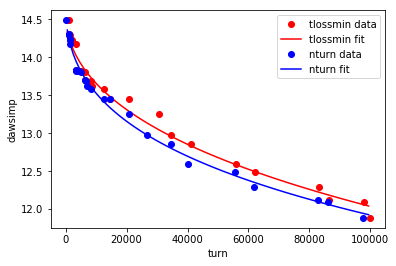

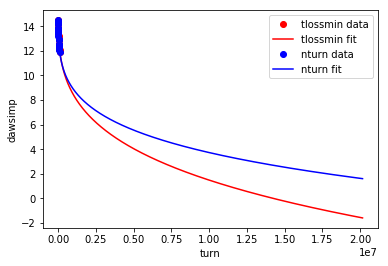

In [70]:
compare_tlossmin_nturn(d,37)

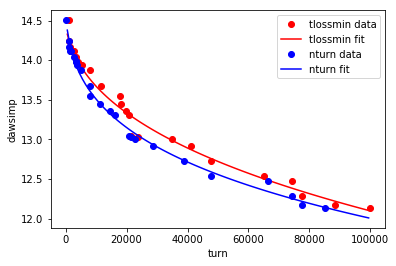

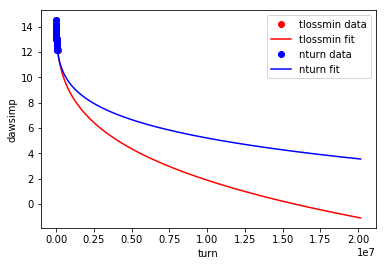

In [73]:
compare_tlossmin_nturn(d,56)

In [82]:
d.data['turnavg'] = (d.data['nturn'] + d.data['tlossmin'])/2

In [86]:
def compare_tlossmin_nturn(d,seed):
    for turns in [100000,30*60*11200]:
        d.fit(seeds=[seed])
        x   = np.arange(500,turns,1000)
        fp  = d.fit_params[d.fit_params['seed']==seed]
        fit = davst_function(x,fp['d'].values,fp['b'].values,fp['k'].values)
        plt.plot(d.cleaned_data['tlossmin'], d.cleaned_data['dawsimp'],'ro',label='tlossmin data')
        plt.plot(x,fit,'r',label='tlossmin fit')

        d.fit(seeds=[seed],xaxis='turnavg')
        x   = np.arange(500,turns,1000)
        fp  = d.fit_params[d.fit_params['seed']==seed]
        fit = davst_function(x,fp['d'].values,fp['b'].values,fp['k'].values)
        plt.plot(d.cleaned_data['turnavg'], d.cleaned_data['dawsimp'],'go',label='turnavg data')
        plt.plot(x,fit,'g',label='turnavg fit')        
        
        d.fit(seeds=[seed],xaxis='nturn')
        x   = np.arange(500,turns,1000)
        fp  = d.fit_params[d.fit_params['seed']==seed]
        fit = davst_function(x,fp['d'].values,fp['b'].values,fp['k'].values)
        plt.plot(d.cleaned_data['nturn'], d.cleaned_data['dawsimp'],'bo',label='nturn data')
        plt.plot(x,fit,'b',label='nturn fit')
        plt.legend()
        plt.xlabel('turn')
        plt.ylabel("dawsimp")
        plt.show()

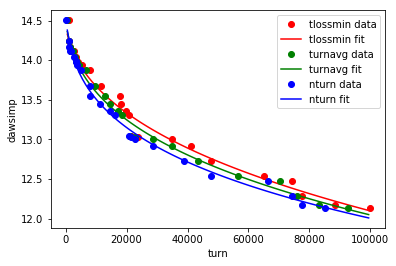

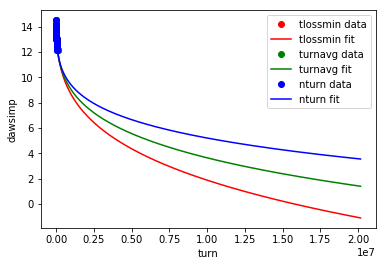

In [87]:
compare_tlossmin_nturn(d,56)

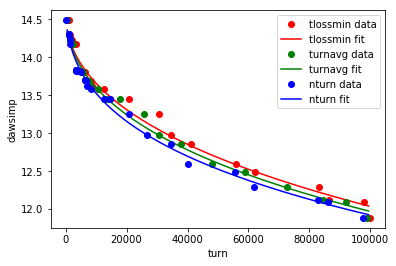

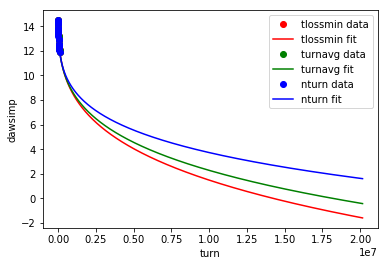

In [88]:
compare_tlossmin_nturn(d,37)

In [137]:
name = basedir+"lhc_b1_inj_2016_qp_{0}_ioct_{1}.db".format(20,40)
d    = davst(name,emit=2.5)
d.get_extrapolated_da(minutes=30)
d.data['turnavg'] = (d.data['nturn'] + d.data['tlossmin'])/2

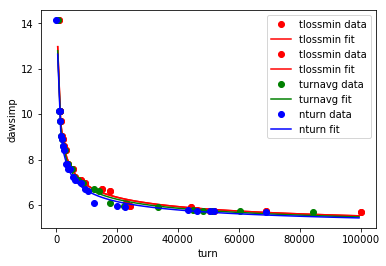

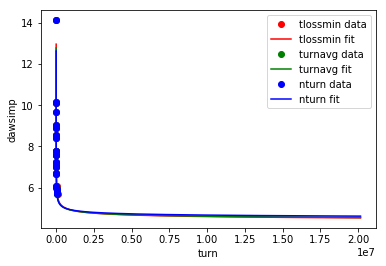

In [138]:
compare_tlossmin_nturn(d,1)

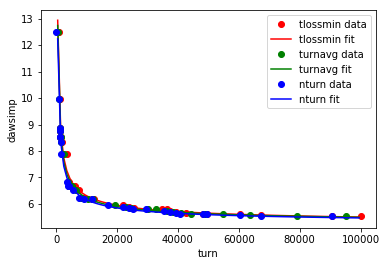

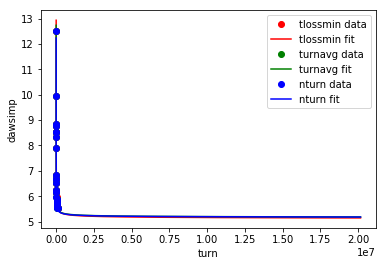

In [139]:
compare_tlossmin_nturn(d,30)

# Comparison of new and old algorithm

In [118]:
d_new = davst('/media/phermes/local/DA_studies/injection_2016/db/lhc_b1_inj_2016_qp_0_ioct_0.db',emit=3.75)
d_old = davst('/home/phermes/development/SixDeskDB/test7_newtloss_chrom-0.0-0.0.db',emit=3.75)

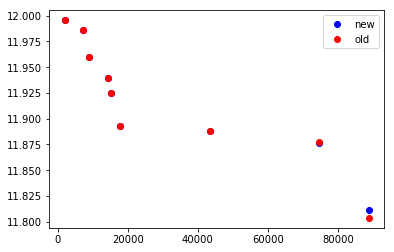

In [124]:
d_new.fit(seeds=[4])
d_new.get_extrapolated_da(minutes=30)
d_old.fit(seeds=[4])
d_old.get_extrapolated_da(minutes=30)

x = np.arange(500,100000,1000)
plt.plot(d_new.cleaned_data['tlossmin'],d_new.cleaned_data['dawsimp'],'bo',label='new')
plt.plot(d_old.cleaned_data['tlossmin'],d_old.cleaned_data['dawsimp'],'ro',label='old')
plt.legend()
plt.show()

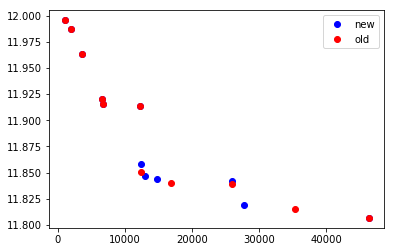

In [123]:
d_new.fit(seeds=[1])
d_new.get_extrapolated_da(minutes=30)
d_old.fit(seeds=[1])
d_old.get_extrapolated_da(minutes=30)

x = np.arange(500,100000,1000)
plt.plot(d_new.cleaned_data['tlossmin'],d_new.cleaned_data['dawsimp'],'bo',label='new')
plt.plot(d_old.cleaned_data['tlossmin'],d_old.cleaned_data['dawsimp'],'ro',label='old')
plt.legend()
plt.show()

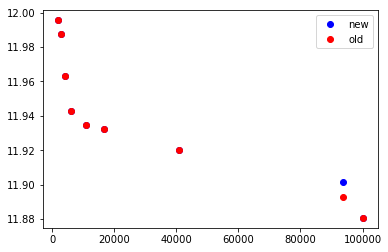

In [125]:
d_new.fit(seeds=[2])
d_new.get_extrapolated_da(minutes=30)
d_old.fit(seeds=[2])
d_old.get_extrapolated_da(minutes=30)

x = np.arange(500,100000,1000)
plt.plot(d_new.cleaned_data['tlossmin'],d_new.cleaned_data['dawsimp'],'bo',label='new')
plt.plot(d_old.cleaned_data['tlossmin'],d_old.cleaned_data['dawsimp'],'ro',label='old')
plt.legend()
plt.show()

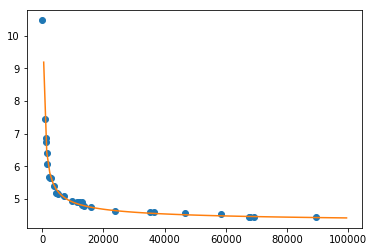

In [37]:
seed = 3
output = []

for k in np.arange(-5,5,0.1):
    d,b,kappa,chisq,derr,berr = dvt.fit_da_kappa(k,seed,xaxis='nturn')
    output.append([d,b,kappa,chisq,derr,berr])
output = pd.DataFrame(output,columns=['d','b','k','chi','derr','berr'])

indx_bestfit = output['chi'].argmin()    # index of the best fit
dfslice      = output.iloc[indx_bestfit]

x = np.arange(500,100000,1000)
plt.plot(dvt.cleaned_data['nturn'],dvt.cleaned_data['dawsimp'],'o')
plt.plot(x,davst_function(x,dfslice['d'],dfslice['b'],dfslice['k']))
plt.show()

In [112]:
dvt = davst('/home/phermes/development/SixDeskDB/test7_newtloss_chrom-0.0-0.0.db',emit=3.75)

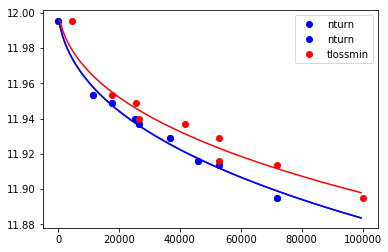

In [116]:
seed = 3
output = []

for k in np.arange(-5,5,0.1):
    d,b,kappa,chisq,derr,berr = dvt._fit_da_single_kappa(k,seed,'nturn')
    output.append([d,b,kappa,chisq,derr,berr])
output = pd.DataFrame(output,columns=['d','b','k','chi','derr','berr'])

indx_bestfit = output['chi'].argmin()    # index of the best fit
dfslice      = output.iloc[indx_bestfit]

x = np.arange(500,100000,1000)
plt.plot(dvt.cleaned_data['nturn'],dvt.cleaned_data['dawsimp'],'bo',label='nturn')
plt.plot(x,davst_function(x,dfslice['d'],dfslice['b'],dfslice['k']),'b')


seed = 3
output = []

for k in np.arange(-5,5,0.1):
    d,b,kappa,chisq,derr,berr = dvt._fit_da_single_kappa(k,seed,'tlossmin')
    output.append([d,b,kappa,chisq,derr,berr])
output = pd.DataFrame(output,columns=['d','b','k','chi','derr','berr'])

indx_bestfit = output['chi'].argmin()    # index of the best fit
dfslice      = output.iloc[indx_bestfit]

x = np.arange(500,100000,1000)
plt.plot(dvt.cleaned_data['tlossmin'],dvt.cleaned_data['dawsimp'],'ro',label='tlossmin')
plt.plot(x,davst_function(x,dfslice['d'],dfslice['b'],dfslice['k']),'r')
plt.legend()
plt.show()

In [117]:
def compare_nturn_tlossmin(dvt.seed):
    output = []

    for k in np.arange(-5,5,0.1):
        d,b,kappa,chisq,derr,berr = dvt._fit_da_single_kappa(k,seed,'nturn')
        output.append([d,b,kappa,chisq,derr,berr])
    output = pd.DataFrame(output,columns=['d','b','k','chi','derr','berr'])

    indx_bestfit = output['chi'].argmin()    # index of the best fit
    dfslice      = output.iloc[indx_bestfit]

    x = np.arange(500,11200*30*60,1000)
    plt.plot(dvt.cleaned_data['nturn'],dvt.cleaned_data['dawsimp'],'bo',label='nturn')
    plt.plot(x,davst_function(x,dfslice['d'],dfslice['b'],dfslice['k']),'b')


    output = []

    for k in np.arange(-5,5,0.1):
        d,b,kappa,chisq,derr,berr = dvt._fit_da_single_kappa(k,seed,'tlossmin')
        output.append([d,b,kappa,chisq,derr,berr])
    output = pd.DataFrame(output,columns=['d','b','k','chi','derr','berr'])

    indx_bestfit = output['chi'].argmin()    # index of the best fit
    dfslice      = output.iloc[indx_bestfit]

    x = np.arange(500,11200*30*60,1000)
    plt.plot(dvt.cleaned_data['tlossmin'],dvt.cleaned_data['dawsimp'],'ro',label='tlossmin')
    plt.plot(x,davst_function(x,dfslice['d'],dfslice['b'],dfslice['k']),'r')
    plt.legend()
    plt.title("Seed {0}".format(seed))
    plt.show()

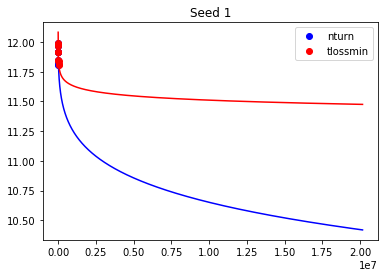

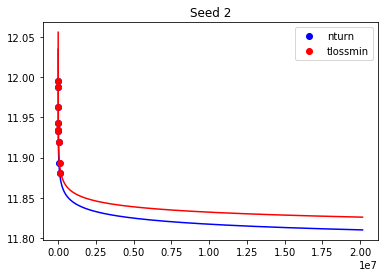

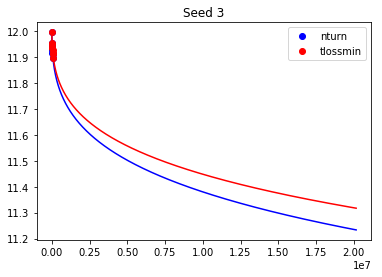

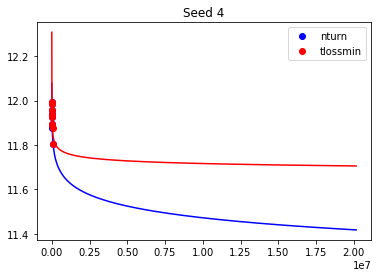

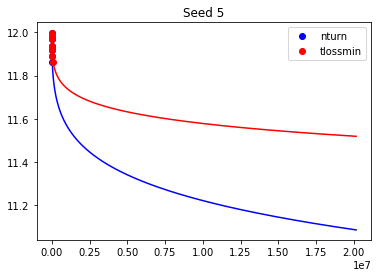

/home/phermes/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


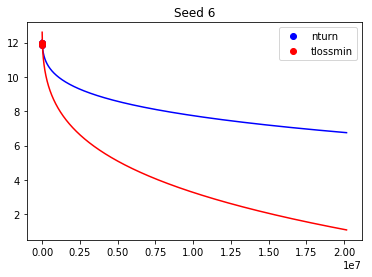

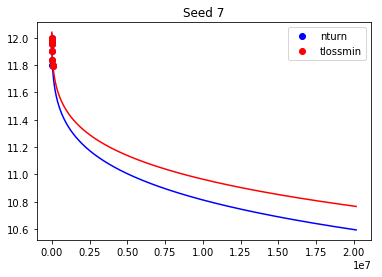

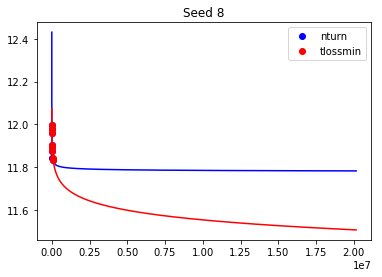

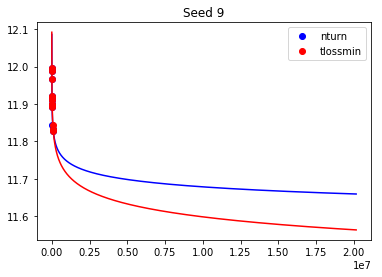

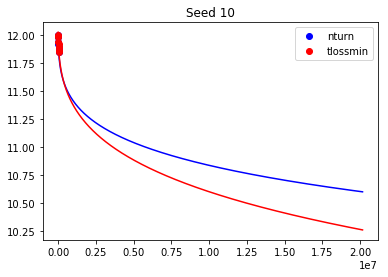

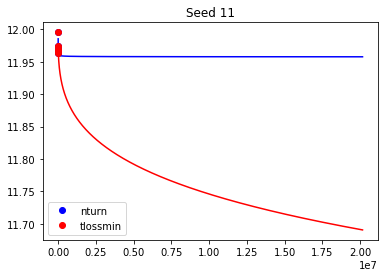

TypeError: Improper input: N=2 must not exceed M=0

In [119]:
for seed in range(1,15):
    compare_nturn_tlossmin(seed)